## Importação das bibliotecas

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt



## Classe DataSet
Esta classe funciona como um container para tratar e armazenar os dados do dataset.

In [2]:
class DataSet:
    """
    Classe para representar um conjunto de dados para treinamento de modelos de machine learning.

    Parâmetros:
        data (DataFrame): O conjunto de dados a ser utilizado para treinamento.
        target (str): O nome da coluna alvo no conjunto de dados.
        test_size (float, opcional): O tamanho da porção de teste. Padrão é 0.2.
        random_state (int, opcional): Semente para a geração de números aleatórios. Padrão é None.
        new_features_funcs (dict, opcional): Dicionário contendo funções para criar novas características.
    """

    def __init__(self, data, target, test_size=0.2, random_state=None, new_features_funcs=None):
        """
        Inicializa uma instância do objeto DataSet.

        Parâmetros:
            data (DataFrame): O conjunto de dados a ser utilizado para treinamento.
            target (str): O nome da coluna alvo no conjunto de dados.
            test_size (float, opcional): O tamanho da porção de teste. Padrão é 0.2.
            random_state (int, opcional): Semente para a geração de números aleatórios. Padrão é None.
            new_features_funcs (dict, opcional): Dicionário contendo funções para criar novas características.
        """
        self.full = {"X": None, "y": None}
        self.train = {"X": None, "y": None}
        self.test = {"X": None, "y": None}

        self.test_size = test_size
        self.random_state = random_state

        data = self.create_new_features(data, new_features_funcs=new_features_funcs)

        self.original = {
            "X": data.drop(target, axis=1),
            "y": data[target]
        }

    def create_new_features(self, data, new_features_funcs=None):
        """
        Cria novas características no conjunto de dados utilizando funções especificadas.

        Parâmetros:
            data (DataFrame): O conjunto de dados a ser modificado.
            new_features_funcs (dict, opcional): Dicionário contendo funções para criar novas características.

        Retorna:
            DataFrame: O conjunto de dados com as novas características, se houver.
        """
        if new_features_funcs is None:
            return data

        for func in new_features_funcs.keys():
            data = new_features_funcs[func](data)

        return data

    def prepare_data(self):
        """
        Prepara o conjunto de dados para treinamento.
        """
        self.full["X"], self.full["y"] = self.__prepare_data()

    def split_data(self):
        """
        Divide o conjunto de dados em conjuntos de treinamento e teste.
        """
        self.train["X"], self.test["X"], self.train["y"], self.test["y"] = self.__split_data()

    def __prepare_data(self):
        """
        Prepara os dados tratando valores ausentes e normalizando as características.

        Retorna:
            tuple: Um par contendo os dados de características (X) e os rótulos (y).
        """
        X = self.original["X"]
        y = self.original["y"]
        imputer = SimpleImputer(strategy='mean')
        X_clean = imputer.fit_transform(X)
        scaler = StandardScaler()
        X_normalized = scaler.fit_transform(X_clean)
        return X_normalized, y

    def __split_data(self):
        """
        Divide os dados em conjuntos de treinamento e teste.

        Retorna:
            tuple: Um par de conjuntos de características e rótulos para treinamento e teste.
        """
        X = self.full["X"]
        y = self.full["y"]
        return train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)


## ClassificationStrategy e Subclasses
O design pattern comportamental strategy foi adotado para a criação das classes dos algoritmos de predição. A classe base ClassificationStrategy traz os métodos auxiliares para tratamento e validação cruzada.
As subclasses herdam estes métodos e ficam responsáveis apenas pela instância dos modelos do sklearn.

In [3]:
class ClassificationStrategy:
    """
    Classe base para estratégias de classificação.

    Atributos:
        model_name (str): Nome do modelo.
        model: Modelo de classificação a ser utilizado.
    """

    def __init__(self, model_name=None):
        """
        Inicializa uma instância do objeto ClassificationStrategy.

        Parâmetros:
            model_name (str, opcional): Nome do modelo. Padrão é None.
        """
        self.model_name = model_name
        self.model = None

    def train(self, X_train, y_train):
        """
        Treina o modelo com os dados de treinamento.

        Parâmetros:
            X_train (array): Conjunto de características de treinamento.
            y_train (array): Rótulos de treinamento.
        """
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        """
        Realiza previsões com base nos dados de teste.

        Parâmetros:
            X_test (array): Conjunto de características de teste.

        Retorna:
            array: Previsões do modelo.
        """
        return self.model.predict(X_test)

    def cross_validate(self, X, y, cv=10, scoring='accuracy', return_train_score=True):
        """
        Executa a validação cruzada do modelo.

        Parâmetros:
            X (array): Conjunto de características.
            y (array): Rótulos.
            cv (int, opcional): Número de dobras para a validação cruzada. Padrão é 10.
            scoring (str, opcional): Métrica de avaliação. Padrão é 'accuracy'.
            return_train_score (bool, opcional): Se deve retornar pontuações de treinamento. Padrão é True.
        """
        self.cv = cv
        self.cv_scores = cross_validate(self.model, X, y, cv=self.cv, scoring=scoring, return_train_score=return_train_score)
        self.score = self.cv_scores['test_score'].mean()

    def cv_plot(self):
        """
        Plota os resultados da validação cruzada.
        """
        if self.model_name is None:
            self.model_name = str(type(self.model)).split(".")[1].split("'")[0]

        f, ax = plt.subplots(1, 1, figsize=(12, 4))

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.plot(range(self.cv), self.cv_scores['train_score'], '-o', markeredgecolor='white',
                color='tab:blue', label='Train')
        ax.plot(range(self.cv), self.cv_scores['test_score'], '-o', markeredgecolor='white',
                color='tab:red', label='Test')
        ax.axhline(self.cv_scores['test_score'].mean(), c='black', alpha=0.3, ls='--',
                   label=f"Acc (test) {self.cv_scores['test_score'].mean().round(2)}")
        ax.set_title(f'Cross Validation Results for {self.model_name}')

        ax.legend()

class DecisionTreeClassification(ClassificationStrategy):
    """
    Classe para estratégia de classificação usando árvore de decisão.

    Herda de ClassificationStrategy.

    Atributos:
        max_depth (int, opcional): Profundidade máxima da árvore. Padrão é None.
    """

    def __init__(self, max_depth=None, model_name=None):
        """
        Inicializa uma instância do objeto DecisionTreeClassification.

        Parâmetros:
            max_depth (int, opcional): Profundidade máxima da árvore. Padrão é None.
            model_name (str, opcional): Nome do modelo. Padrão é None.
        """
        self.max_depth = max_depth
        self.model_name = model_name
        self.model = DecisionTreeClassifier(max_depth=self.max_depth)


class KNNClassification(ClassificationStrategy):
    """
    Classe para estratégia de classificação usando o algoritmo KNN (K-Nearest Neighbors).

    Herda de ClassificationStrategy.

    Atributos:
        n_neighbors (int, opcional): Número de vizinhos a serem considerados. Padrão é 5.
    """

    def __init__(self, n_neighbors=5, model_name=None):
        """
        Inicializa uma instância do objeto KNNClassification.

        Parâmetros:
            n_neighbors (int, opcional): Número de vizinhos a serem considerados. Padrão é 5.
            model_name (str, opcional): Nome do modelo. Padrão é None.
        """
        self.n_neighbors = n_neighbors
        self.model_name = model_name
        self.model = KNeighborsClassifier(n_neighbors=self.n_neighbors)

class LogisticRegressionClassification(ClassificationStrategy):
    """
    Classe para estratégia de classificação usando regressão logística.

    Herda de ClassificationStrategy.
    """

    def __init__(self, model_name=None):
        """
        Inicializa uma instância do objeto LogisticRegressionClassification.

        Parâmetros:
            model_name (str, opcional): Nome do modelo. Padrão é None.
        """
        self.model_name = model_name
        self.model = LogisticRegression()


## A Fachada
Foi utilizado o design pattern estrutural façade para organizar toda a complexidade das classes do sistema.

In [4]:
class MLFacade:
    """
    Classe para facilitar a seleção e treinamento de modelos de machine learning.

    Atributos:
        data_set (DataSet): Conjunto de dados para treinamento.
        models (dict): Dicionário contendo os modelos de classificação.
        best_model (str): Nome do melhor modelo selecionado.
        best_score (float): Pontuação do melhor modelo selecionado.
    """

    def __init__(self, data_set, models):
        """
        Inicializa uma instância do objeto MLFacade.

        Parâmetros:
            data_set (DataSet): Conjunto de dados para treinamento.
            models (dict): Dicionário contendo os modelos de classificação.
        """
        self.data_set = data_set
        self.models = models
        self.best_model = None
        self.best_score = None

    def select_best_model(self, cv=10, scoring='accuracy'):
        """
        Seleciona o melhor modelo com base na validação cruzada.

        Parâmetros:
            cv (int, opcional): Número de dobras para a validação cruzada. Padrão é 10.
            scoring (str, opcional): Métrica de avaliação. Padrão é 'accuracy'.

        Retorna:
            str: Nome do melhor modelo selecionado.
        """
        self.data_set.prepare_data()
        for model_name, model in self.models.items():
            model.cross_validate(self.data_set.full["X"], self.data_set.full["y"], cv=cv, scoring=scoring)
            if self.best_score is None or model.score > self.best_score:
                self.best_score = model.score
                self.best_model = model_name
        return self.best_model

    def train_best_model(self):
        """
        Treina o melhor modelo selecionado com os dados de treinamento.

        Retorna:
            ClassificationStrategy: Melhor modelo treinado.
        """
        self.data_set.split_data()
        model = self.models[self.best_model]
        model.train(self.data_set.train["X"], self.data_set.train["y"])
        return model

    def generate_cv_evaluation_summary(self):
        """
        Gera um resumo da avaliação utilizando validação cruzada para cada modelo.
        """
        for model_name, model in self.models.items():
            print(model_name)
            model.cv_plot()

    def generate_evaluation_summary(self):
        """
        Gera um resumo da avaliação do melhor modelo selecionado.
        """
        def summary(ds):
            X, y = ds["X"], ds["y"]
            y_pred = self.models[self.best_model].predict(X)
            print("Classification Report:")
            print(classification_report(y, y_pred))
            print("Confusion Matrix:")
            disp = ConfusionMatrixDisplay.from_predictions(y, y_pred)
            disp.ax_.set_title('Matriz de Confusão')
            plt.show()

            if len(np.unique(y)) == 2:
                fpr, tpr, _ = roc_curve(y, y_pred)
                roc_auc = auc(fpr, tpr)

                # Interpola os pontos para obter mais pontos na curva ROC
                interp_fpr = np.linspace(0, 1, 100)
                interp_tpr = np.interp(interp_fpr, fpr, tpr)

                # Plota a curva ROC interpolada
                plt.figure()
                plt.plot(interp_fpr, interp_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('Receiver Operating Characteristic')
                plt.legend(loc="lower right")
                plt.show()

        print(f"Best Model: {self.best_model}")
        summary(self.data_set.full)
        summary(self.data_set.train)
        summary(self.data_set.test)


## Tratamento do dataset

Algumas operações são necessárias para tratar o dataset, de forma que ele possa apresentar os dados corretos para as classes do sistema.

É importante ressaltar que neste momento a abordagem estruturada é mais adequada, pois os tratamentos para separar os discos, selecionar colunas, adicionar coluna de target são bem peculiares ao conjunto de dados original, assim, são operações com baixa possibilidade de abstração.

Os conjuntos finais tem 45 e 49 músicas cada, compreendendo os cinco discos de estúdio com Bon Scott e os cinco primeiros álbuns de estúdio com Brian Johnson, respectivamente.

In [5]:
#Carregando o dataset
df=pd.read_csv("acdc_spotify_data.csv")

#Removendo discos ao vivo
linhas_para_deletar = df[df['album_name'].str.contains('Live')]
df = df.drop(linhas_para_deletar.index)

#Convertendo a data de lançamento para o formato de data
df['release_date']=pd.to_datetime(df['release_date'])

#Separando o dataframe pela data de lançamento
##A fase Bon Scott vai até 1979, ano de sua morte
df_bon_scott=df[df['release_date'].dt.year<1980].copy()
df_bon_scott['target']=0
##A fase Brian Johnson vai de 1980 em diante, mas para equilibrar o conjunto,
##vamos utilizar os discos até 1988
df_brian_johnson=df[(df['release_date'].dt.year>1979) & (df['release_date'].dt.year<1988)].copy()
df_brian_johnson['target']=1

#Visualizando o shape dos dataframes
print(df_brian_johnson.shape,df_bon_scott.shape)

#Combinando os datasets
data=pd.concat([df_bon_scott, df_brian_johnson], ignore_index=True)[
    ['target','valence', 'liveness', 'energy', 'danceability',
     'instrumentalness', 'speechiness', 'tempo', 'acousticness',
     'duration_ms', 'loudness']
    ]

(49, 24) (45, 24)


Os modelos são definidos em um dicionário que é passado para a classe MLFacade.

É importante ressaltar que foram feitos dois modelos de decision tree, com a única diferença no max_depth, com o intuito de demonstrar um modelo com overfitting.

In [6]:
# Definir modelos
models = {
    'Decision Tree1': DecisionTreeClassification(model_name='Decision Tree 1'),
    'Decision Tree2': DecisionTreeClassification(max_depth=3, model_name='Decision Tree 2'),
    'KNN': KNNClassification(),
    'Logistic Regression': LogisticRegressionClassification()
}

A classe DataSet permite a criação de novas features. As mesmas devem ser criadas por meio de funções, que retornam o próprio dataframe. Aqui, dois parâmetros são criados, param1 e param2, que combinam os parâmetros duration_ms e tempo; e instrumentalness e speechiness, respectivamente.

In [7]:
def param1(data):
    data['param1']=data['duration_ms']*data['tempo']
    return data

def param2(data):
    data['param2']=data['instrumentalness']*data['speechiness']
    return data

new_features={
    "param1": param1,
    "param2": param2
}

Finalmente as classes são instanciadas, sendo criadas as instâncias do dataset e da fachada.

In [8]:

# Instanciar classes
data_set = DataSet(data,'target', random_state=42, new_features_funcs=None)

ml_facade = MLFacade(data_set, models)


O primeiro passo é fazer a seleção do melhor modelo por meio da validação cruzada.

Nesse ponto é escolhido o algoritmo com melhor acurácia na validação cruzada. Nos gráficos é possível observar que o modelo decision tree 1 apresenta overfitting.

In [9]:
# Treinar e selecionar melhor modelo
best_model_name = ml_facade.select_best_model()



Após a seleção do melhor algoritmo, o modelo então é treinado, é mostrado o sumário dos resultados com precision, recall, f1-score e acurácia.
A matriz de confusão também é mostrada, além da curva roc (apenas quando o problema de classificação é binário).
Este sumário é mostrado para (i) o conjunto total de dados; (ii) o conjunto de treinamento; e (iii) o conjunto de teste.

In [10]:
# Treinar melhor modelo selecionado
best_model = ml_facade.train_best_model()



Decision Tree1
Decision Tree2
KNN
Logistic Regression


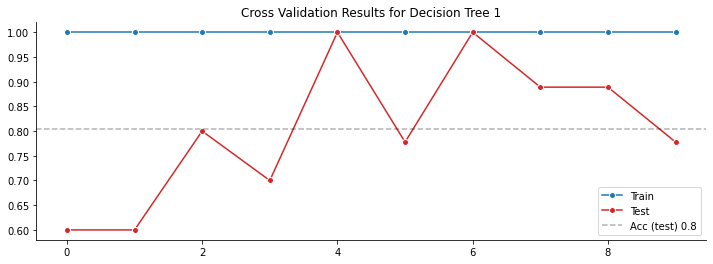

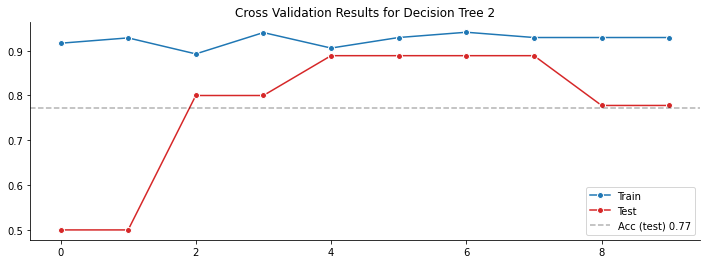

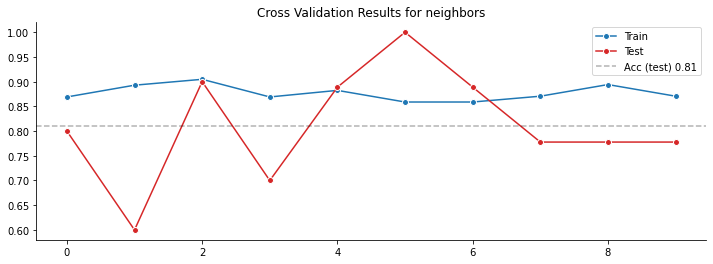

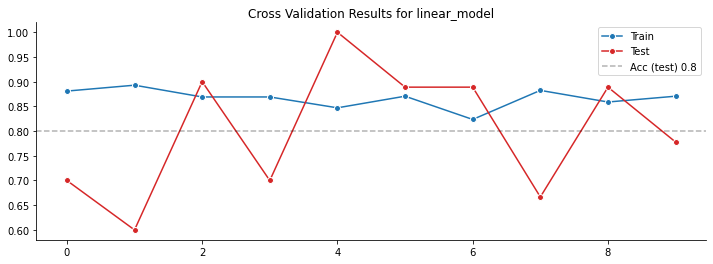

In [11]:
# Gerar resumo de avaliação
ml_facade.generate_cv_evaluation_summary()


Best Model: KNN
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.73      0.84        45
           1       0.80      0.98      0.88        49

    accuracy                           0.86        94
   macro avg       0.89      0.86      0.86        94
weighted avg       0.88      0.86      0.86        94

Confusion Matrix:


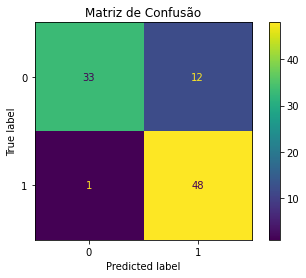

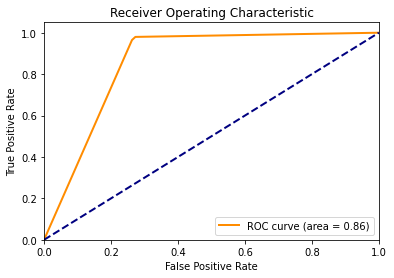

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.76      0.86        33
           1       0.84      1.00      0.91        42

    accuracy                           0.89        75
   macro avg       0.92      0.88      0.89        75
weighted avg       0.91      0.89      0.89        75

Confusion Matrix:


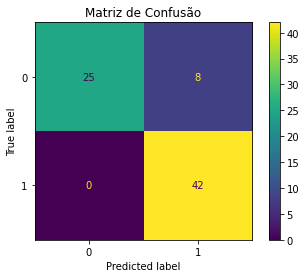

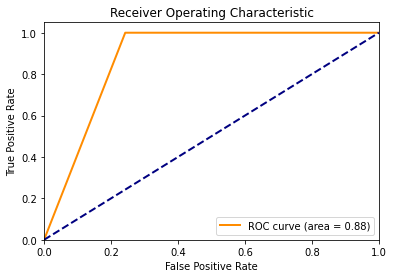

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.60      0.86      0.71         7

    accuracy                           0.74        19
   macro avg       0.74      0.76      0.73        19
weighted avg       0.78      0.74      0.74        19

Confusion Matrix:


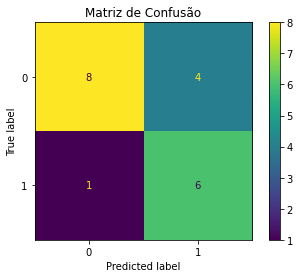

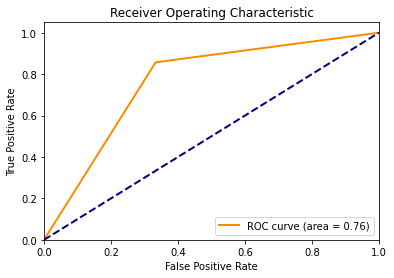

In [12]:
# Gerar resumo de avaliação
ml_facade.generate_evaluation_summary()
